<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/Noise_CL_with_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup and upload file

In [16]:
# Step 1: Install necessary libraries
!pip install librosa matplotlib tensorflow requests

# Step 2: Import necessary libraries
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

Saving 5-9032-A-0.wav to 5-9032-A-0 (1).wav


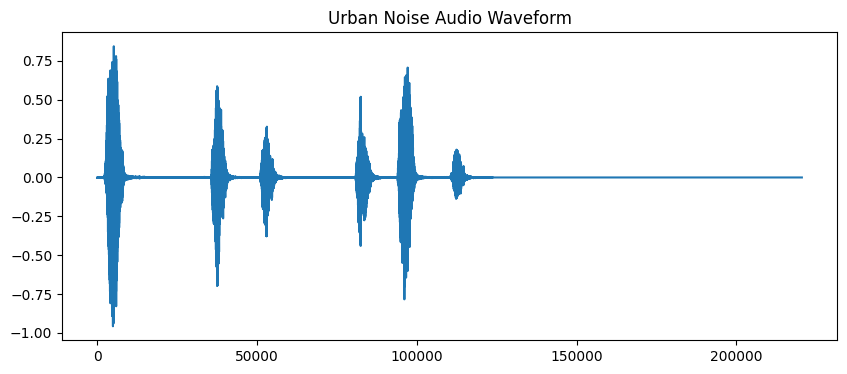

In [17]:

# Step 3: Upload audio file from local computer
uploaded = files.upload()

audio_file = next(iter(uploaded))  # This will grab the name of the first uploaded file

# Step 4: Load the downloaded urban noise sample
def load_audio(file_path):
    # Load audio file using librosa
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

audio_data, sr = load_audio(audio_file)

# Plot the waveform of the downloaded audio
plt.figure(figsize=(10, 4))
plt.plot(audio_data)
plt.title('Urban Noise Audio Waveform')
plt.show()

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 110s 856ms/step - loss: 0.0325 - val_loss: 9.0401e-04
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 140s 837ms/step - loss: 0.0138 - val_loss: 0.0011
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 104s 843ms/step - loss: 0.0053 - val_loss: 7.8651e-04
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 104s 840ms/step - loss: 0.0031 - val_loss: 3.4225e-04
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 139s 817ms/step - loss: 0.0021 - val_loss: 2.7662e-04
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 812ms/step - loss: 0.0016 - val_loss: 1.5642e-04
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 146s 853ms/step - loss: 0.0013 - val_loss: 1.9328e-04
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 101s 813ms/step - loss: 0.0012 - val_loss: 1.4427e-04
Epoch 9/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 101s 818ms/step - loss: 0.0012 - val_loss: 6.1903e-05
Epoch 10/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 144s 835ms/step - loss: 0.0010 - val_loss: 7.4730e-05
310/310 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step


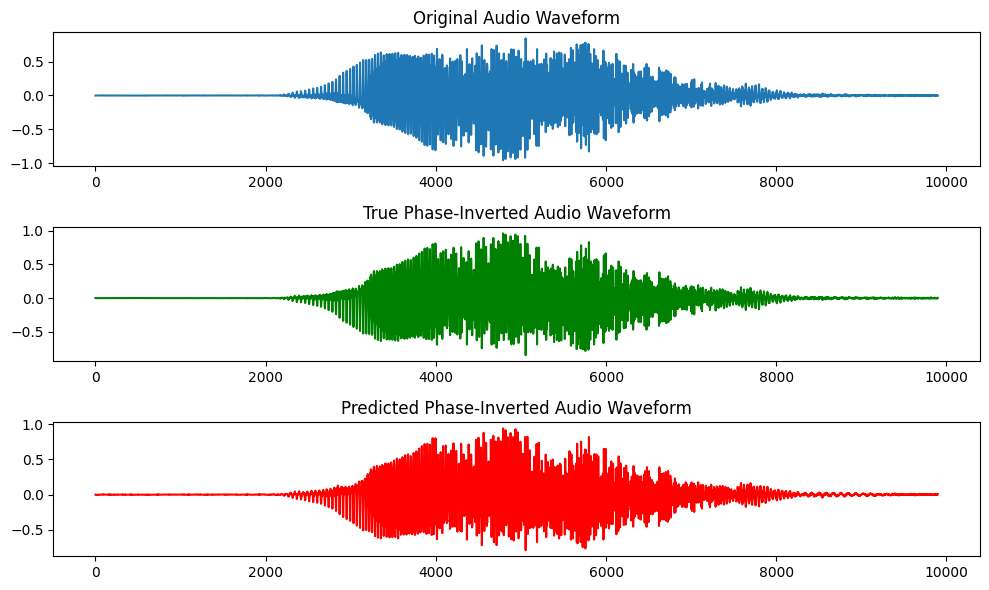

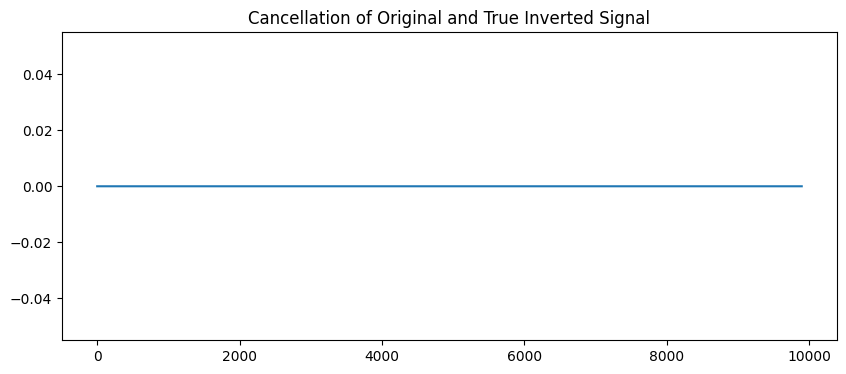

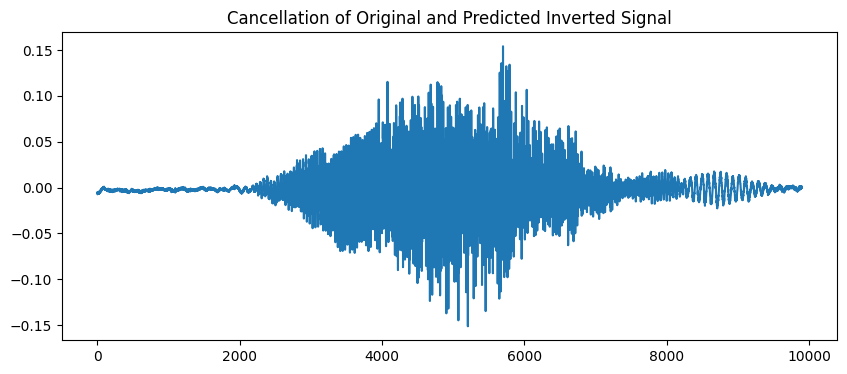

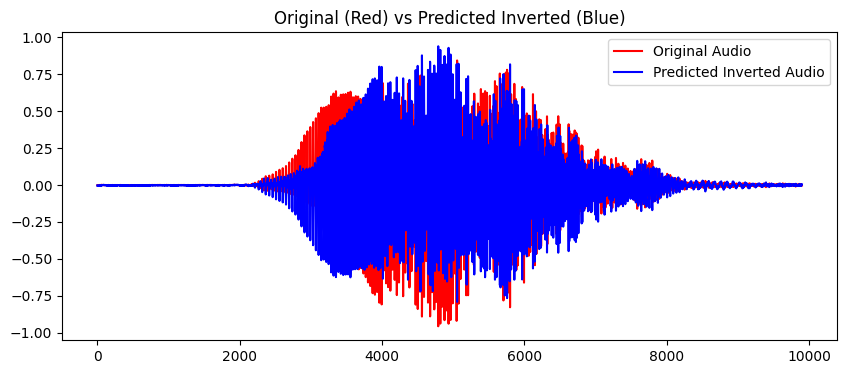

In [18]:
# Step 5: Prepare Data for Model
def prepare_data(audio, time_steps, sample_size=None):
    X, y = [], []
    if sample_size:  # Reduce dataset size for faster training
        audio = audio[:sample_size]
    for i in range(len(audio) - time_steps):
        X.append(audio[i:i + time_steps])
        # Target is the phase-inverted signal 180 degrees
        y.append(-audio[i + time_steps])  # Inverted signal for destructive interference
    return np.array(X), np.array(y)

# Define the time step for LSTM
time_steps = 100  # Increased time steps for more context

# Use a moderate sample size for training
sample_size = 10000  # Larger dataset to improve model learning

# Prepare input-output pairs for training
X, y = prepare_data(audio_data, time_steps, sample_size)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input

# Step 6: Define Improved LSTM Model
model = Sequential()
model.add(Input(shape=(time_steps, 1)))  # Input layer
model.add(LSTM(256, return_sequences=True))  # First LSTM layer with 256 units
model.add(Dropout(0.3))  # Dropout for regularization
model.add(LSTM(128, return_sequences=False))  # Second LSTM layer with 128 units
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(1))  # Output layer

# Compile model with a lower learning rate for finer training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

# Early stopping to prevent overfitting and ensure optimal training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 7: Train the model (increased to 10 epochs, early stopping enabled)
history = model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Step 8: Evaluate the model on the same data (or upload a new test audio file)
y_pred = model.predict(X)

# Step 9: Visualize the Results

# Plot original, predicted, and true inverted waveforms
plt.figure(figsize=(10, 6))

# Plot original audio
plt.subplot(3, 1, 1)
plt.plot(audio_data[time_steps:sample_size], label='Original Audio')
plt.title('Original Audio Waveform')

# Plot true phase-inverted audio
plt.subplot(3, 1, 2)
plt.plot(-audio_data[time_steps:sample_size], label='True Inverted Audio', color='g')
plt.title('True Phase-Inverted Audio Waveform')

# Plot predicted inverted audio
plt.subplot(3, 1, 3)
plt.plot(y_pred, label='Predicted Inverted Audio', color='r')
plt.title('Predicted Phase-Inverted Audio Waveform')

plt.tight_layout()
plt.show()

# Step 10: Measure cancellation effectiveness between original and true inverted signal
# Combine the original signal with the true phase-inverted signal for cancellation
true_canceled_signal = audio_data[time_steps:sample_size] + (-audio_data[time_steps:sample_size])

# Plot cancellation of original and true inverted signal
plt.figure(figsize=(10, 4))
plt.plot(true_canceled_signal)
plt.title('Cancellation of Original and True Inverted Signal')
plt.show()

# Step 11: Measure cancellation effectiveness between original and predicted inverted signal
# Combine the original signal with the predicted phase-inverted signal for cancellation
predicted_canceled_signal = audio_data[time_steps:sample_size] + y_pred.squeeze()

# Plot cancellation of original and predicted inverted signal
plt.figure(figsize=(10, 4))
plt.plot(predicted_canceled_signal)
plt.title('Cancellation of Original and Predicted Inverted Signal')
plt.show()

# Step 12: Plot original vs predicted for comparison
plt.figure(figsize=(10, 4))
plt.plot(audio_data[time_steps:sample_size], label='Original Audio', color='r')
plt.plot(y_pred, label='Predicted Inverted Audio', color='b')
plt.title('Original (Red) vs Predicted Inverted (Blue)')
plt.legend()
plt.show()